# Описание задачи и критерий оценки результата

ЧТО НУЖНО БУДЕТ СДЕЛАТЬ:

1. Скачать и загрузить датасет.
2. Отрисовать один батч загруженных данных.
3. Выбрать предобученную модель.
4. Обучить многоклассовый классификатор, используя выбранную модель.
5. Визуализировать предсказания модели.
6. Выбрать подходящие метрики качества и посчитать их для обученной модели.
7. Построить матрицу ошибок, определить, каких людей модель путает чаще всего.
8. Попробовать улучшить качество модели, решая задачу в 2 этапа: сначала выполняя детекцию лица, затем выполняя классификацию по кропу лица (для детекции можно использовать любой известный вам подход). 
9. Описать полученные результаты в текстовой ячейке ноутбука.

Основная цель: **accuracy > 0.85** на валидационной выборке.

# Импорт необходимых библиотек

In [2]:
import os
import cv2
import torch
import datetime
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, models, transforms
from typing import List, Union, Tuple, Dict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



# for visualization
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
%matplotlib inline
plt.style.use('ggplot')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Загрузка данных

In [ ]:
# создадим отображение int в лейблы, соответствующие знаменитостям в датасете

label_map = dict(enumerate(os.listdir('./data/train')))
print(f'Label maping: {label_map}')

# проверим, все ли размерыности изображений в датасете одинаковы

img_shape_dict = {}

for folder in os.listdir('./data'):
    for foldername in os.listdir(os.path.join('./data', folder)):
        for filename in os.listdir(os.path.join('./data', folder, foldername)):
            f = os.path.join('./data', folder, foldername, filename)
            if os.path.isfile(f):
                img_shape = cv2.imread(f).shape
                try:
                    img_shape_dict[str(img_shape)] += 1
                except:
                    img_shape_dict[str(img_shape)] = 1
                    
print(f'Shape of images: {img_shape_dict}')

Label maping: {0: 'bill_gates', 1: 'elon_musk', 2: 'jeff_bezos', 3: 'mark_zuckerberg', 4: 'steve_jobs'}
Shape of images: {'(70, 70, 3)': 3913, '(285, 229, 3)': 1}


In [ ]:
# так как в датасете присутствуют в основном изображения 70х70,
# то будем проводить resize всех подаваемых в модель изображений

train_transforms = transforms.Compose(
    [
        transforms.Resize((70, 70)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # переводим изображение в PyTorch tensor
        # далее будем использовать предобученную модель Resnet, поэтому нормализуем
        # изображения с теми же коэффициентами, что и в ImageNet, на котором обучали Resnet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose([
        transforms.Resize((70, 70)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

In [ ]:
path_to_data = 'data'

training_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'train'),
    transform=train_transforms
)

test_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'valid'),
    transform=test_transforms
)

In [ ]:
# def get_subset(indices, start, end):
#     return indices[start : start + end]

# TEST_PCT, VALIDATION_PCT = 0.5, 0.5
# test_count = int(len(test_data) * TEST_PCT)
# validation_count = int(len(test_data) * VALIDATION_PCT)

# indices = torch.randperm(len(test_data))

# validation_indices = get_subset(indices, 0, validation_count)
# test_indices = get_subset(indices, validation_count, test_count)

In [ ]:
batch_size = 8

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(f'Number of batches in train subset: {len(train_dataloader)}')
print(f'Number of batches in test subset:  {len(test_dataloader)}')

Number of batches in train subset: 376
Number of batches in test subset:  115


In [ ]:
# функция для отображения изображений
def imshow(img):
    plt.figure(figsize=(16, 4))
    img = img.numpy().transpose((1, 2, 0))
    # проведем операцию, обратную нормализации
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

In [ ]:
# получим батч из тренировочных данных
inputs, classes = next(iter(train_dataloader))

# и отобразим его
out = torchvision.utils.make_grid(inputs)
imshow(out)

# Построение циклов обучения и валидации

Для начала напишем собственный класс, который будем использовать в дальнейшем для визуализации результатов:

In [ ]:
class MyLogWriter:
    """
    Класс для записи числовых значений для последующего построения графиков.
    Данные хранятся в dict.
    """
    def __init__(self):
        self.log_dict = {}

    def add_label(self, labels: List[str]) -> None:
        for label in labels:
            self.log_dict[label] = []
    
    def add_value(self, label: str, value: Union[int, float]) -> None:
        self.log_dict[label].append(value)
    
    def __len__(self) -> int:
        return len(self.log_dict)

    def __call__(self) -> Dict[str, List]:
        return self.log_dict

    def __getitem__(self, label: str) -> List[Union[int, float]]:
        return self.log_dict[label]


class MyPlotter:
    """
    Класс для построения и сохранения графиков.
    На вход принимает словарь.
    """
    def __init__(self, path: str, logs: Dict[str, List[Union[int, float]]]) -> None:
        self.path = path
        self.logs = logs

    def plot_graph(
        self,
        xlabel: str,
        ylabel: str,
        labels: List[str],
        title: str,
        figsize: Tuple[int]=(5, 5),
        save: bool=True
    ) -> None:

        fig, ax = plt.subplots(figsize=figsize, layout="constrained")

        for label in labels:
            ax.plot(self.logs[label], label=label)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title(title)
            ax.legend()

        if save:
            # создаем новую папку для сохранения графика
            new_path = os.path.join(self.path, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
            os.makedirs(new_path, exist_ok=True)
            # сохраняем в отдельную переменную текущую рабочую директорию
            current_path = os.getcwd()
            # меняем текущую рабочую директорию на созданную папку
            os.chdir(new_path)
            # сохраняем график
            fig.savefig(f'{title}.png')
            # меняем текущую рабочую директорию обратно
            os.chdir(current_path)

Цикл обучения:

In [ ]:
# опишем цикл обучения

def train_loop(dataloader, model, loss_fn, optimizer, epoch_n, device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)

    train_loss, train_accuracy = 0, 0
    model.train()
    with tqdm(dataloader, unit='batch') as tepoch:
        for images, labels in tepoch:

            # Определяем описание для tqdm
            tepoch.set_description(f'Epoch {epoch_n}')

            images, labels = images.to(device), labels.to(device)
            # Делаем forward pass
            pred = model(images)
            # вычисляем loss
            loss = loss_fn(pred, labels)

            # Вычисляем градиенты
            optimizer.zero_grad()
            loss.backward()

            # Делаем шаг оптимизатора
            optimizer.step()

            # Вычисляем количество правильных ответов
            correct = (pred.argmax(1) == labels).sum().item()
            accuracy = correct / batch_size

            # Прибавляем loss и accuracy к полным значениям за эпоху
            train_loss += loss.item()
            train_accuracy += correct
            # Выводим в tqdm текущие лосс и точность
            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)

    # вычисляем среднее
    train_loss /= num_batches
    train_accuracy /= len_of_dataset

    # # Записываем в тензорборд
    # summary_writer.add_scalar(
    #     'train/loss',
    #     train_loss,
    #     epoch_n
    # )

    # summary_writer.add_scalar(
    #     'train/accuracy',
    #     train_accuracy,
    #     epoch_n
    # )

    summary_writer.add_value(
        'train_loss',
        train_loss
    )

    summary_writer.add_value(
        'train_accuracy',
        train_accuracy
    )

Цикл валидации:

In [ ]:
# опишем цикл для валидации/теста

def test_loop(dataloader, model, loss_fn, epoch_n,  device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    
    # На этапе валидации нам не нужно вычислять градиенты
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= len_of_dataset

    # summary_writer.add_scalar(
    #     'test/loss',
    #     test_loss,
    #     epoch_n
    # )

    # summary_writer.add_scalar(
    #     'test/accuracy',
    #     correct,
    #     epoch_n
    # )

    summary_writer.add_value(
        'test_loss',
        test_loss
    )

    summary_writer.add_value(
        'test_accuracy',
        correct
    )

    print(f'Test Metrics: \n Accuracy: {(correct):>0.3f}, Avg loss: {test_loss:>8f} \n')

In [ ]:
def make_predictions(dataloader, model, device):
    actual, preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            preds.append(pred)
            actual.append(labels)
    # gc.collect()
    actual, preds = torch.cat(actual), torch.cat(preds)
    return actual.cpu().detach().numpy(), F.softmax(preds, dim=-1).argmax(dim=-1)

# Использование предобученной модели Resnet

## Transfer learning Resnet

In [ ]:
# инициализируем предобученную модель Resnet для последующего переноса обучения
model_freeze_conv = models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights)

# заморозим веса всей модели
for param in model_freeze_conv.parameters():
    param.requires_grad = False

# создадим переменную, в которую запишем количество входных признаков для последнего слоя
# модели, являющегося итоговым классификатором (classification head модели)
number_of_features = model_freeze_conv.fc.in_features

# производим замену classification head и указываем необходимое количество выходных классов
model_freeze_conv.fc = nn.Linear(number_of_features, len(label_map))

# отправляем модель на устройство (в нашем случае GPU)
model_freeze_conv = model_freeze_conv.to(device)

# инициализируем функцию потерь
loss_fn = nn.CrossEntropyLoss()

# в качестве оптимизатора указываем SGD с momentum, который использовался в оригинальной модели Resnet
optimizer = optim.SGD(model_freeze_conv.fc.parameters(), lr=0.001, momentum=0.9)

# попробуем с другим оптимизатором
# optimizer = optim.AdamW(model_freeze_conv.fc.parameters(), lr=0.001)

C:\Users\Home\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
%reload_ext tensorboard

In [ ]:
%load_ext tensorboard

Запускаем обучение, значения метрик будут записываться в экземпляр класса MyLogWriter:

In [ ]:
num_of_epochs = 10

# writer = SummaryWriter('runs/resnet_ft') # при использовании Tensorboard
writer = MyLogWriter()

for epoch_n in range(num_of_epochs):
    train_loop(train_dataloader, model_freeze_conv, loss_fn, optimizer, num_of_epochs, device, writer)
    test_loop(test_dataloader, model_freeze_conv, loss_fn, num_of_epochs, device, writer)

# writer.close()
print("Done!")

  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.779, Avg loss: 0.638135 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.794, Avg loss: 0.612781 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.789, Avg loss: 0.602750 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.807, Avg loss: 0.569594 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.805, Avg loss: 0.547263 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.814, Avg loss: 0.504490 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.827, Avg loss: 0.531790 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.839, Avg loss: 0.461870 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.826, Avg loss: 0.535018 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.855, Avg loss: 0.464296 

Done!


Строим и сохраняем графики с результатами метрик:

In [ ]:
loss_plotter = MyPlotter('./results/loss', writer)

loss_plotter.plot_graph(
    xlabel='epoch',
    ylabel='loss',
    labels=['train_loss', 'test_loss'],
    title='Loss',
    figsize=(5, 5),
    save=True)
)

In [ ]:
acc_plotter = MyPlotter('./results/accuracy', writer)

acc_plotter.plot_graph(
    xlabel='epoch',
    ylabel='loss',
    labels=['train_accuracy', 'test_accuracy'],
    title='Loss',
    figsize=(5, 5),
    save=True)
)

In [ ]:
actual, preds = make_predictions(model_freeze_conv, test_dataloader, device)
actual, preds = torch.tensor(actual).cpu(), torch.tensor(preds).cpu()

In [ ]:
print('\nClassification report: ')
print(classification_report(actual, preds, target_names=label_map.values()))
print('\nConfusion Matrix: ')
print(confusion_matrix(actual, preds))

In [ ]:
%tensorboard --logdir runs/

Reusing TensorBoard on port 6006 (pid 33256), started 2:49:28 ago. (Use '!kill 33256' to kill it.)

## Fine tuning Resnet

In [ ]:
# инициализируем предобученную модель Resnet для последующего переноса обучения
model = models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights)

# создадим переменную, в которую запишем количество входных признаков для последнего слоя
# модели, являющегося итоговым классификатором (classification head модели)
number_of_features = model.fc.in_features

# производим замену classification head и указываем необходимое количество выходных классов
model.fc = nn.Linear(number_of_features, len(label_map))

# отправляем модель на устройство (в нашем случае GPU)
model = model.to(device)

# инициализируем функцию потерь
loss_fn = nn.CrossEntropyLoss()

# в качестве оптимизатора указываем SGD с momentum, который использовался в оригинальной модели Resnet
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Face detection + transfer learning Resnet

Скачиваем обученную модель детекции лиц:

In [ ]:
!mkdir face_detector
# !wget "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel" -q -O ./face_detector/model.caffemodel
# !wget "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt" -q -O ./face_detector/model.prototxt

!curl -so ./face_detector/model.caffemodel "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel" 
!curl -so ./face_detector/model.prototxt "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"

Подпапка или файл face_detector уже существует.


In [ ]:
PATH_TO_WEIGHTS = './face_detector/model.caffemodel'
PATH_TO_PROTOTXT = './face_detector/model.prototxt'

net = cv2.dnn.readNetFromCaffe(PATH_TO_PROTOTXT, PATH_TO_WEIGHTS)

Детекция будет включена в виде лямбда-функции для torchvision.transforms.Compose, поэтому обернем в отдельную функцию обработку входящего изображения для инференса предварительно обученной модели детекции:

In [ ]:
def detect_face(img):
    # изображение из PyTorch Dataloader поступает в виде объекта PIL.Image.Image,
    # поэтому для удобства конвертируем в numpy.ndarray
    img = np.asarray(img)
    h, w = img.shape[:2]

    blob = cv2.dnn.blobFromImage(
                img,
                1.0,
                (300, 300), (104.0, 177.0, 123.0)
            )

    net.setInput(blob)
    detections = net.forward()
    img_copy = img.copy()

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.3:
            box = (detections[0, 0, i, 3:7] * np.array([w, h, w, h])).astype(np.int32)
            # обрезаем изображение по границам детектированного лица
            crop = img_copy[box[1]:box[3], box[0]:box[2]]
            # прервем цикл, так как в нашей задаче подразумевается наличие на входном
            # изображении одного лица, а модель детекции способна детектировать
            # несколько лиц с одного изображения
            break

    return Image.fromarray(crop) # переводим обратно в формат PIL.Image.Image

In [ ]:
img = detect_face(cv2.imread('./data/train/bill_gates/00715f3e-b281-4199-91c7-7da7a8475d7b.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

<class 'numpy.ndarray'>


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
# так как в датасете присутствуют в основном изображения 70х70,
# то будем проводить resize всех подаваемых в модель изображений

train_transforms = transforms.Compose(
    [
        transforms.Lambda(detect_face),
        transforms.Resize((70, 70)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # переводим изображение в PyTorch tensor
        # далее будем использовать предобученную модель Resnet, поэтому нормализуем
        # изображения с теми же коэффициентами, что и в ImageNet, на котором обучали Resnet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Lambda(detect_face),
        transforms.Resize((70, 70)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

In [ ]:
path_to_data = 'data'

training_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'train'),
    transform=train_transforms
)

test_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'valid'),
    transform=test_transforms
)

In [ ]:
batch_size = 8

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(f'Number of batches in train subset: {len(train_dataloader)}')
print(f'Number of batches in test subset:  {len(test_dataloader)}')

Number of batches in train subset: 376
Number of batches in test subset:  115


In [ ]:
# функция для отображения изображений
def imshow(img):
    plt.figure(figsize=(16, 4))
    img = img.numpy().transpose((1, 2, 0))
    # проведем операцию, обратную нормализации
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

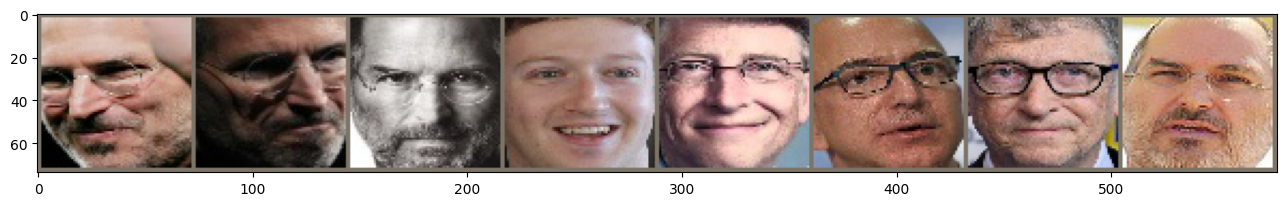

In [ ]:
# получим батч из тренировочнх данных
inputs, classes = next(iter(train_dataloader))

# и отобразим его
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [ ]:
# инициализируем предобученную модель Resnet для последующего переноса обучения
model_freeze_conv_det = models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights)

# заморозим веса всей модели
for param in model_freeze_conv_det.parameters():
    param.requires_grad = False

# создадим переменную, в которую запишем количество входных признаков для последнего слоя
# модели, являющегося итоговым классификатором (classification head модели)
number_of_features = model_freeze_conv_det.fc.in_features

# производим замену classification head и указываем необходимое количество выходных классов
model_freeze_conv_det.fc = nn.Linear(number_of_features, len(label_map))

# отправляем модель на устройство (в нашем случае GPU)
model_freeze_conv_det = model_freeze_conv_det.to(device)

# инициализируем функцию потерь
loss_fn = nn.CrossEntropyLoss()

# в качестве оптимизатора указываем SGD с momentum, который использовался в оригинальной модели Resnet
optimizer = optim.SGD(model_freeze_conv_det.fc.parameters(), lr=0.001, momentum=0.9)